In [1]:
%config IPCompleter.use_jedi = False

In [2]:
import pandas as pd
from pathlib import Path

## Load and Clean

In [3]:
data_path = Path('.') / 'data' / 'raw' / 'sent'
data_path.exists()

True

In [4]:
driver_files = list(data_path.glob('driver*.csv'))
team_files = list(data_path.glob('team*.csv'))

In [5]:
def load_from_files(files):
    df = pd.concat([pd.read_csv(f, sep='|').dropna() for f in files])
    df.drop('Unnamed: 0', axis='columns', inplace=True)
    entity_col = df.columns[0]
    
    # Clean fields that should be numeric
    df = str_to_numeric(df, cols=['Sentiment', 'Current Price', 'Season Start PriceSeason Price'])
    df['ts'] = pd.to_datetime(df['ts'])
    return df[[entity_col, 'ts'] + list(df.columns[1:-1])].sort_values(by=[entity_col, 'ts']).reset_index(drop=True)

In [6]:
def str_to_numeric(df, cols):
    for col in cols:
        df[col] = df[col].str.replace('[\%\$m]', '', regex=True).astype(float)
    return df

In [7]:
drivers = load_from_files(driver_files)
teams = load_from_files(team_files)

In [8]:
drivers

,Driver,ts,12 Hour,3 Hour,Latest,Sentiment,Current Price,Season Start PriceSeason Price,Points/Million
0,Alex Albon ALB Williams,2022-06-12 15:42:57,0,0,0,-97.0,7.8,7.5,1.23
1,Alex Albon ALB Williams,2022-06-12 15:52:24,0,0,0,-97.0,7.8,7.5,1.23
2,Alex Albon ALB Williams,2022-06-12 17:10:49,2,1,0,-96.0,7.8,7.5,1.23
3,Alex Albon ALB Williams,2022-06-12 23:24:40,1,0,0,-96.0,7.8,7.5,1.23
4,Alex Albon ALB Williams,2022-06-13 09:07:54,1,0,0,-95.0,7.8,7.5,1.23
...,...,...,...,...,...,...,...,...,...
1235,Yuki Tsunoda TSU AlphaTauri,2022-07-22 07:21:19,-1,0,0,-74.0,8.3,8.5,0.51
1236,Yuki Tsunoda TSU AlphaTauri,2022-07-23 09:09:27,5,7,1,-73.0,8.3,8.5,0.51
1237,Yuki Tsunoda TSU AlphaTauri,2022-07-24 09:57:56,-1,-1,-1,-71.0,8.3,8.5,0.46
1238,Yuki Tsunoda TSU AlphaTauri,2022-07-25 09:22:05,-1,0,0,-72.0,8.3,8.5,0.45


In [9]:
teams

,Team,ts,12 Hour,3 Hour,Latest,Sentiment,Current Price,Season Start PriceSeason Price,Points/Million
0,Alfa Romeo,2022-06-12 15:42:57,-6.0,-1.0,0.0,-26.0,8.7,8.0,1.87
1,Alfa Romeo,2022-06-12 15:52:24,-7.0,-2.0,-1.0,-27.0,8.7,8.0,1.87
2,Alfa Romeo,2022-06-12 17:10:49,-6.0,0.0,1.0,-26.0,8.7,8.0,1.87
3,Alfa Romeo,2022-06-12 23:24:40,-3.0,0.0,0.0,-27.0,8.7,8.0,1.87
4,Alfa Romeo,2022-06-13 09:07:54,-3.0,-1.0,0.0,-30.0,8.7,8.0,1.87
...,...,...,...,...,...,...,...,...,...
605,Williams,2022-07-22 07:21:19,-1.0,0.0,0.0,-32.0,7.1,7.0,1.29
606,Williams,2022-07-23 09:09:27,1.0,2.0,0.0,-32.0,7.1,7.0,1.29
607,Williams,2022-07-24 09:57:56,-58.0,-58.0,-15.0,-58.0,6.7,7.0,1.24
608,Williams,2022-07-25 09:22:05,-67.0,-24.0,-5.0,-67.0,6.5,7.0,1.27


## Compare

In [10]:
diff_cols = ['ts', '12 Hour', '3 Hour', 'Latest', 'Sentiment', 'Current Price']

In [11]:
drivers_a = drivers.join(drivers.groupby(['Driver'], as_index=False)[diff_cols].diff(), rsuffix=' diff')

In [12]:
teams_a = teams.join(teams.groupby(['Team'], as_index=False)[diff_cols].diff(), rsuffix=' diff')

## Changes

In [13]:
cond_driver_price_change = (drivers_a['Current Price diff'].notna()) & (drivers_a['Current Price diff'] != 0)
drivers_a[cond_driver_price_change].dropna().sort_values(by='ts')

,Driver,ts,12 Hour,3 Hour,Latest,Sentiment,Current Price,Season Start PriceSeason Price,Points/Million,ts diff,12 Hour diff,3 Hour diff,Latest diff,Sentiment diff,Current Price diff
1061,Sergio Perez PER Red Bull,2022-06-13 16:20:06,1,1,1,1.0,18.3,17.5,1.82,0 days 03:59:51,-9.0,-2.0,1.0,-97.0,0.1
632,Lewis Hamilton HAM Mercedes,2022-06-15 10:22:25,0,0,99,0.0,30.0,31.0,0.65,0 days 23:00:47,99.0,99.0,99.0,99.0,-0.1
266,Fernando Alonso ALO Alpine,2022-06-18 12:31:44,5,5,1,5.0,12.3,12.5,0.64,0 days 04:22:05,-8.0,3.0,-1.0,-88.0,0.1
81,Charles Leclerc LEC Ferrari,2022-06-18 14:25:02,-94,-94,-58,-94.0,18.9,18.0,1.66,0 days 01:53:18,-59.0,-88.0,-56.0,-14.0,-0.1
329,George Russell RUS Mercedes,2022-06-18 14:25:02,15,15,-84,15.0,23.8,24.0,1.31,0 days 01:53:18,22.0,10.0,-85.0,-64.0,0.1
1011,Sebastian Vettel VET Aston Martin,2022-06-18 14:25:02,54,54,48,54.0,11.5,11.5,0.90,0 days 01:53:18,-1.0,39.0,46.0,1.0,0.1
82,Charles Leclerc LEC Ferrari,2022-06-18 15:01:00,-48,-48,46,-48.0,18.8,18.0,1.67,0 days 00:35:58,46.0,46.0,104.0,46.0,-0.1
268,Fernando Alonso ALO Alpine,2022-06-18 15:01:00,6,6,-69,6.0,12.4,12.5,0.64,0 days 00:35:58,-69.0,-65.0,-104.0,-69.0,0.1
888,Pierre Gasly GAS AlphaTauri,2022-06-18 15:01:00,9,9,-90,9.0,13.0,13.5,0.82,0 days 00:35:58,-9.0,-11.0,-103.0,-90.0,0.1
579,Lando Norris NOR Mclaren,2022-06-19 09:05:33,0,0,0,-4.0,15.7,16.0,1.01,0 days 18:04:33,50.0,37.0,11.0,94.0,-0.1


In [14]:
cond_team_price_change = (teams_a['Current Price diff'].notna()) & (teams_a['Current Price diff'] != 0)
teams_a[cond_team_price_change].dropna()

,Team,ts,12 Hour,3 Hour,Latest,Sentiment,Current Price,Season Start PriceSeason Price,Points/Million,ts diff,12 Hour diff,3 Hour diff,Latest diff,Sentiment diff,Current Price diff
27,Alfa Romeo,2022-06-21 07:07:51,-3.0,0.0,85.0,-3.0,8.6,8.0,2.07,0 days 09:37:52,1.0,0.0,85.0,88.0,-0.1
38,Alfa Romeo,2022-07-01 17:09:46,1.0,0.0,1.0,1.0,8.5,8.0,2.09,1 days 08:27:56,0.0,-1.0,0.0,88.0,-0.1
145,Alpine,2022-06-20 01:20:07,5.0,1.0,0.0,5.0,14.0,14.0,1.40,0 days 08:06:32,-8.0,-10.0,-3.0,-93.0,0.1
202,Aston Martin,2022-06-18 15:01:00,23.0,23.0,9.0,23.0,11.1,11.5,1.49,0 days 02:29:16,20.0,30.0,8.0,-62.0,0.1
208,Aston Martin,2022-06-20 10:05:56,1.0,1.0,-1.0,1.0,11.2,11.5,1.56,0 days 02:07:08,-73.0,-23.0,-7.0,-94.0,0.1
225,Aston Martin,2022-07-05 08:29:01,-87.0,-87.0,2.0,-87.0,11.1,11.5,1.65,0 days 18:20:57,-87.0,-87.0,3.0,2.0,-0.1
233,Aston Martin,2022-07-10 18:39:38,-1.0,0.0,1.0,-1.0,11.0,11.5,1.64,1 days 02:58:53,0.0,0.0,1.0,96.0,-0.1
324,Haas,2022-06-18 15:01:00,-6.0,-6.0,-2.0,-6.0,6.3,6.0,0.69,0 days 02:29:16,1.0,-5.0,-2.0,93.0,-0.1
362,Haas,2022-07-23 09:09:27,0.0,-4.0,0.0,0.0,6.4,6.0,1.42,1 days 01:48:08,-3.0,-6.0,-1.0,-86.0,0.1
408,Mclaren,2022-07-05 08:29:01,-24.0,-24.0,58.0,-24.0,17.5,18.5,1.06,0 days 18:20:57,-24.0,-24.0,57.0,58.0,-0.1


## Inspection

In [15]:
drivers_a.set_index('Driver').filter(like='Perez', axis=0)

,ts,12 Hour,3 Hour,Latest,Sentiment,Current Price,Season Start PriceSeason Price,Points/Million,ts diff,12 Hour diff,3 Hour diff,Latest diff,Sentiment diff,Current Price diff
Driver,,,,,,,,,,,,,,
Sergio Perez PER Red Bull,2022-06-12 15:42:57,27,7,1,73.0,18.2,17.5,1.83,NaT,NaN,NaN,NaN,NaN,NaN
Sergio Perez PER Red Bull,2022-06-12 15:52:24,30,10,3,76.0,18.2,17.5,1.83,0 days 00:09:27,3.0,3.0,2.0,3.0,0.0
Sergio Perez PER Red Bull,2022-06-12 17:10:49,34,12,4,82.0,18.2,17.5,1.83,0 days 01:18:25,4.0,2.0,1.0,6.0,0.0
Sergio Perez PER Red Bull,2022-06-12 23:24:40,26,1,0,87.0,18.2,17.5,1.83,0 days 06:13:51,-8.0,-11.0,-4.0,5.0,0.0
Sergio Perez PER Red Bull,2022-06-13 09:07:54,9,2,0,95.0,18.2,17.5,1.83,0 days 09:43:14,-17.0,1.0,0.0,8.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sergio Perez PER Red Bull,2022-07-22 07:21:19,-2,0,0,-10.0,18.3,17.5,1.48,7 days 23:22:47,-10.0,0.0,0.0,54.0,-0.1
Sergio Perez PER Red Bull,2022-07-23 09:09:27,-37,-24,-3,-65.0,18.3,17.5,1.48,1 days 01:48:08,-35.0,-24.0,-3.0,-55.0,0.0
Sergio Perez PER Red Bull,2022-07-24 09:57:56,1,0,0,-72.0,18.3,17.5,1.46,1 days 00:48:29,38.0,24.0,3.0,-7.0,0.0


In [16]:
drivers_a.groupby('ts')['12 Hour'].agg(lambda x: x[x > 0].sum())

ts
2022-06-12 15:42:57    149
2022-06-12 15:52:24    153
2022-06-12 17:10:49     91
2022-06-12 23:24:40     57
2022-06-13 09:07:54     31
                      ... 
2022-07-22 07:21:19     21
2022-07-23 09:09:27    214
2022-07-24 09:57:56     46
2022-07-25 09:22:05     32
2022-07-25 21:53:15    105
Name: 12 Hour, Length: 62, dtype: int64

<AxesSubplot:xlabel='ts'>

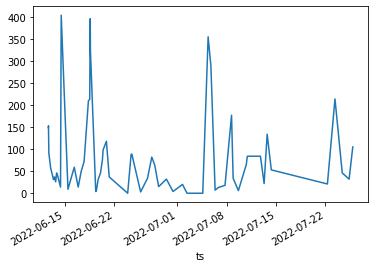

In [17]:
drivers_a.groupby('ts')['12 Hour'].agg(lambda x: x[x > 0].sum()).plot()

In [18]:
drivers_a.groupby('ts')['12 Hour'].agg(lambda x: x[x < 0].sum()).abs()

ts
2022-06-12 15:42:57    107
2022-06-12 15:52:24    107
2022-06-12 17:10:49     57
2022-06-12 23:24:40     32
2022-06-13 09:07:54     17
                      ... 
2022-07-22 07:21:19     18
2022-07-23 09:09:27    147
2022-07-24 09:57:56     76
2022-07-25 09:22:05     57
2022-07-25 21:53:15     65
Name: 12 Hour, Length: 62, dtype: int64